<a href="https://colab.research.google.com/github/martinpius/MachineTranslation/blob/main/Bigram_language_model_with_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from timeit import default_timer as timer
t1 = timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch, random
  from torch.nn import functional as F
  from tqdm.auto import tqdm
  import matplotlib.pyplot as plt
  print(f">>>> You are in Google CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload your device")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h}, mins: {m:>02}, secs: {s:>05.2f}"
print(f">>>> Available device: {device}")
!nvidia-smi
print(f">>>> Time elapsed:\t {mytimer(timer() - t1)}")

Mounted at /content/drive/
>>>> You are in Google CoLaB with torch version: 2.0.0+cu118
>>>> Available device: cpu
/bin/bash: nvidia-smi: command not found
>>>> Time elapsed:	 hrs: 0, mins: 00, secs: 04.00


* We train the simplest language model on a character level. The aim is to predict the probability of the next
letter in a sequence of 2 letters [bigram]. The best model is the one which maximizes this probability. Reference for this notebook and dataset see https://github.com/karpathy/makemore

In [5]:
# We start by importing the data: The dataset we employ for this project is a list of names. Our task is to build a 
# character level language model to generate new names according to multinomial probability distribution


In [6]:
path_file = "/content/drive/MyDrive/Language models/makemore-master/names.txt"
names = open(path_file, "r").read().splitlines()

In [7]:
# Simple explorations of the names dataset:
print(f">>>> Total number of unique names in the dataset: {len(names)}\
\n>>>> The longest name has a total of {max([len(name) for name in names])} characters\
\n>>>> The shortest name has a total of {min([len(name) for name in names])} characters")

>>>> Total number of unique names in the dataset: 32033
>>>> The longest name has a total of 15 characters
>>>> The shortest name has a total of 2 characters


In [21]:
# Build a looup dictionary to convert characters into numeric and vice-versa
def myLookup(words_list):

  all_chars = sorted(list(set(''.join(words_list)))) # obtain the list of unique characters in the dataset
  assert len(all_chars) == 26 # All unique chars in english language
  stoi = {s: i + 1 for i, s in enumerate(all_chars)} # map every character to a numeric index [we start at 1 to allow zero padding]
  stoi["."] = 0 # There are 26 unique characters in english language, we add the special char "." for padding
  itos = {i:s for s, i in stoi.items()} # Reverse the lookup dictionary to map indices back to characters 

  return all_chars, stoi, itos



In [22]:
all_chars, stoi, itos = myLookup(names)

In [23]:
print(f">>>> All unique characters in the dataset:\n>>>> {all_chars}\
\n>>>> stoi: {stoi}\n>>>> itos: {itos}")

>>>> All unique characters in the dataset:
>>>> ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
>>>> stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
>>>> itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
# We now fit the simplest bigram language model by obtain the probability matrix for every possible pairs of 
# Characters in the sequence of 27 unique characters

In [25]:
rows, cols = len(stoi), len(itos)
M = torch.zeros(rows, cols) # An empty table to hold the counts 
assert M.shape == (27, 27)

In [26]:
for name in names:
  char = ["."] + list(name) + ["."]
  for ch1, ch2 in zip(char, char[1:]): # iterate on consecutive characters (pairwise)
    idx1, idx2 = stoi[ch1], stoi[ch2] # grab the indices
    M[idx1, idx2] += 1 # obtaining the frequencies of every pair of characters
    

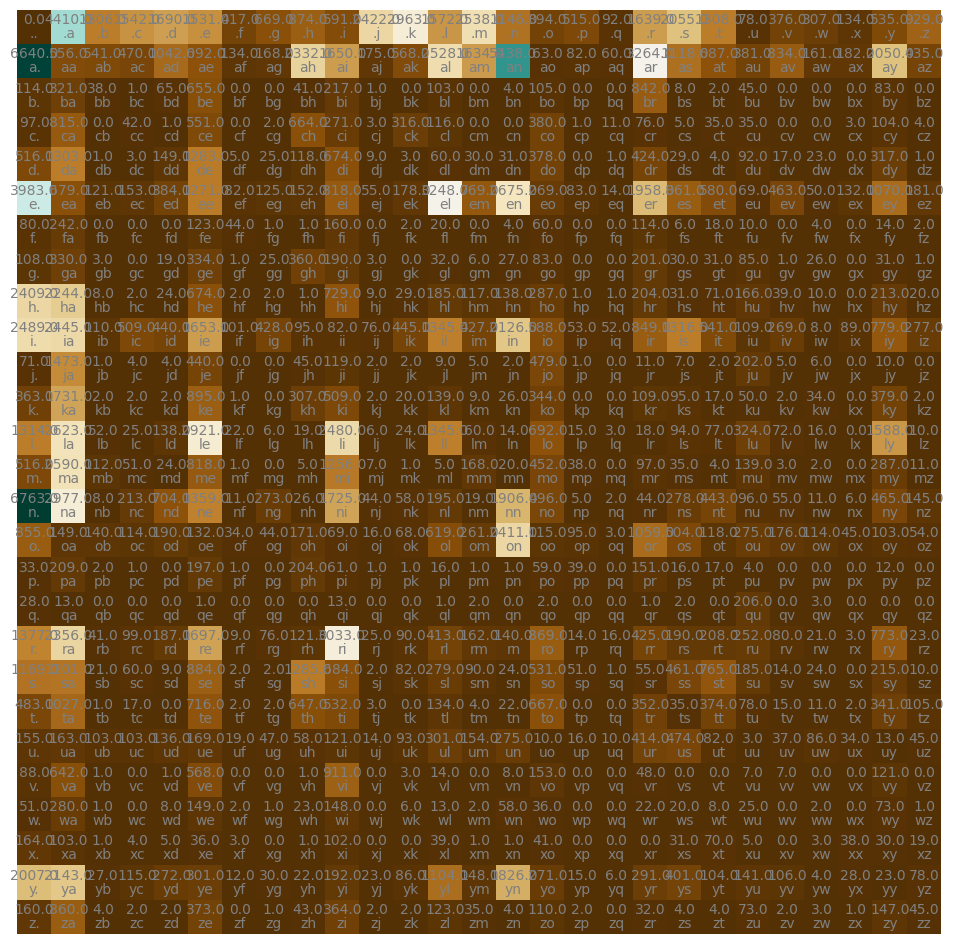

In [30]:
# Vizualization of the bigram table of frequencies
plt.figure(figsize = (12, 12))
plt.imshow(M, cmap = plt.cm.BrBG)
for i in range(rows):
  for j in range(cols):
    chars = itos[i] + itos[j] # get the paired characters
    plt.text(j, i, chars, va = "top", ha = "center", color = "gray")
    plt.text(j, i, M[i, j].item(), va = "bottom", ha = "center", color = "gray")
    plt.axis("off")

In [31]:
# The rows represent the count of the next letter given the first letter already occured. For the bigram language model
# We compute this conditional probability and sampling according to the multinomial probability distributio to generate
# any possible names

In [33]:
P = (M + 1).float() # We smoothes the count matrix with a min of 1 to avoid zero probabilities
P /= P.sum(dim = 1, keepdims = True) # We normalizes by the rows total [sum accross the columns]
assert P[0].sum() == 1

* We finally obtain our probability distribution P which represent the chance of two characters being next to each other
* Since P is a multinomial distributed random variable we can now sample new names accordingly

In [36]:
gen = torch.Generator().manual_seed(2918272727)

for i in range(30):
  out = []
  idx = 0 # For every name we start at the begining "."
  while True:
    p = P[idx] # fetch the probabilities of the next char given the first already occured
    idx = torch.multinomial(p, num_samples = 1, replacement = True,
                            generator = gen).item() # We sample the index of the possible character according to Multinomial distribution
    
    out.append(itos[idx]) # Append the respective token 
    if idx == 0: # We terminate the loop when the end of a name is reached
      break
  print(f">>>> Name number {i+1} sampled is:==> {''.join(out)}")



>>>> Name number 1 sampled is:==> nnian.
>>>> Name number 2 sampled is:==> ghya.
>>>> Name number 3 sampled is:==> l.
>>>> Name number 4 sampled is:==> paudaela.
>>>> Name number 5 sampled is:==> lotowana.
>>>> Name number 6 sampled is:==> g.
>>>> Name number 7 sampled is:==> sannyeibanduiy.
>>>> Name number 8 sampled is:==> jami.
>>>> Name number 9 sampled is:==> al.
>>>> Name number 10 sampled is:==> adae.
>>>> Name number 11 sampled is:==> marenanafyla.
>>>> Name number 12 sampled is:==> lyck.
>>>> Name number 13 sampled is:==> dora.
>>>> Name number 14 sampled is:==> canan.
>>>> Name number 15 sampled is:==> a.
>>>> Name number 16 sampled is:==> e.
>>>> Name number 17 sampled is:==> neranyvauni.
>>>> Name number 18 sampled is:==> ceraqvaaniere.
>>>> Name number 19 sampled is:==> ny.
>>>> Name number 20 sampled is:==> d.
>>>> Name number 21 sampled is:==> ma.
>>>> Name number 22 sampled is:==> arirethadaynieyand.
>>>> Name number 23 sampled is:==> iya.
>>>> Name number 24 sampled is

In [37]:
# To evaluate the performance of our bigram language model we can compute the likelihood loss. This is because we would
# like to maximize the probability of the next character given the first in a sequence of two characters

In [41]:
log_l = 0
num = 0
for name in names[:30]: # We print for the first 30 names
  ch = ["."] + list(name) + ["."]
  for ch1, ch2 in zip(ch, ch[1:]):
    idx1, idx2 = stoi[ch1], stoi[ch2]
    p = P[idx1, idx2] # fetch the respective probability for the bigram
    ll = -p.log().item() # get the negative loglikelihood for the respective bigram
    log_l += ll
    num += 1
    print(f">>>> Average loss for a bigram: {itos[idx1], itos[idx2]} is: {log_l / num:.4f}")
    


>>>> Average loss for a bigram: ('.', 'e') is: 3.0410
>>>> Average loss for a bigram: ('e', 'm') is: 3.1602
>>>> Average loss for a bigram: ('m', 'm') is: 3.3319
>>>> Average loss for a bigram: ('m', 'a') is: 2.7353
>>>> Average loss for a bigram: ('a', '.') is: 2.5143
>>>> Average loss for a bigram: ('.', 'o') is: 2.8280
>>>> Average loss for a bigram: ('o', 'l') is: 2.7887
>>>> Average loss for a bigram: ('l', 'i') is: 2.6563
>>>> Average loss for a bigram: ('i', 'v') is: 2.8261
>>>> Average loss for a bigram: ('v', 'i') is: 2.6482
>>>> Average loss for a bigram: ('i', 'a') is: 2.5875
>>>> Average loss for a bigram: ('a', '.') is: 2.5078
>>>> Average loss for a bigram: ('.', 'a') is: 2.4674
>>>> Average loss for a bigram: ('a', 'v') is: 2.5558
>>>> Average loss for a bigram: ('v', 'a') is: 2.4785
>>>> Average loss for a bigram: ('a', '.') is: 2.4255
>>>> Average loss for a bigram: ('.', 'i') is: 2.5177
>>>> Average loss for a bigram: ('i', 's') is: 2.5222
>>>> Average loss for a bigr

# We can also estimate the bigram probability matrix M using neural networks. 
# We now implement the simplest single linear layer neural net to optimize the 
# weights of the bigram language model 

In [47]:
# Data preparation for training a bigram language model
def build_languageData(words_list, split):
  
  random.seed(123467)
  random.shuffle(words_list)
  n1 = int(len(words_list) * 0.8)
  n2 = int(len(words_list) * 0.9)
  # data splitting
  train = words_list[:n1]
  valid = words_list[n1:n2]
  test = words_list[n2:]
  inputs, targets = [], []
  if split == "train":
    for name in train:
      ch = ["."] + list(name) + ["."]
      for ch1, ch2 in zip(ch, ch[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        inputs.append(idx1)
        targets.append(idx2)
  elif split == "valid":
    for name in valid:
      ch = ["."] + list(name) + ["."]
      for ch1, ch2 in zip(ch, ch[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        inputs.append(idx1)
        targets.append(idx2)
  elif split == "test":
    for name in test:
      ch = ["."] + list(name) + ["."]
      for ch1, ch2 in zip(ch, ch[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        inputs.append(idx1)
        targets.append(idx2)
  else: print(f">>>> Invalid split")

  inputs, targets = torch.tensor(inputs), torch.tensor(targets)
  return inputs, targets


In [48]:
X_tr, Y_tr = build_languageData(words_list= names, split = "train")
X_v, Y_v = build_languageData(words_list= names, split = "valid")
X_t, Y_t = build_languageData(words_list= names, split = "test")

In [49]:
print(f">>>> X_train shape: {X_tr.shape}, Y_train shape: {Y_tr.shape}\
\n>>>> X_val shape: {X_v.shape}, Y_val shape: {Y_v.shape}\
\n>>>> X_test shape: {X_t.shape}, Y_test shape: {Y_t.shape}")

>>>> X_train shape: torch.Size([182566]), Y_train shape: torch.Size([182566])
>>>> X_val shape: torch.Size([22701]), Y_val shape: torch.Size([22701])
>>>> X_test shape: torch.Size([22845]), Y_test shape: torch.Size([22845])


In [103]:
input, target = [], []
for w in names[:]:
  ch = ["."] + list(w) + ["."]
  for ch1, ch2 in zip(ch, ch[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    input.append(ix1)
    target.append(ix2)
input = torch.tensor(input)
target = torch.tensor(target)

In [111]:
# Parameters initialization:
gen = torch.Generator().manual_seed(1928374)
W = torch.randn(size = (27, 27), generator = gen, requires_grad= True)


In [112]:
# We train our single layer neural network to approximate the transition probability matrix for the bigram language model

In [113]:
nll = 0
steps = []
losses = []
EPOCHS = 500
for epoch in range(EPOCHS):
  ix = torch.randint(0, input.shape[0], (256,)) # training with min-batches of 32 
  X_hot = F.one_hot(input[ix], num_classes = 27).float() # Encoding the indices to one-hot
  # Forward pass
  logits = X_hot @ W # A simple linear layer with no bias vector and non-linearity transformation
  #probs = F.softmax(logits, dim = 1)
  exp = logits.exp()
  probs = exp / exp.sum(dim = 1, keepdims = True) # obtaining the softmax layer
  tr_loss = -probs[torch.arange(len(target[ix])), target[ix]].log().mean() # obtaining the neg-likelihood loss
  print(f">>>> Epoch: {epoch + 1 if epoch == 0 else epoch}\
  :\t Train Loss: {tr_loss.item():.4f}")

  W.grad = None # reset the gragients to zero: same as optimizer.zero_grad()
  l2 = (W**2).mean() # l2-penalty to force the model to learn small weights

  # Backward pass
  tr_loss.backward()
  # gradient stepping
  LR = 45 
  W.data += -55 * W.grad + 0.001 * l2
  steps.append(epoch)
  losses.append(tr_loss.item())
  

>>>> Epoch: 1  :	 Train Loss: 3.7503
>>>> Epoch: 1  :	 Train Loss: 3.4480
>>>> Epoch: 2  :	 Train Loss: 3.1701
>>>> Epoch: 3  :	 Train Loss: 3.1200
>>>> Epoch: 4  :	 Train Loss: 3.0381
>>>> Epoch: 5  :	 Train Loss: 2.8379
>>>> Epoch: 6  :	 Train Loss: 2.9166
>>>> Epoch: 7  :	 Train Loss: 2.7725
>>>> Epoch: 8  :	 Train Loss: 2.7496
>>>> Epoch: 9  :	 Train Loss: 2.6365
>>>> Epoch: 10  :	 Train Loss: 2.7630
>>>> Epoch: 11  :	 Train Loss: 2.7730
>>>> Epoch: 12  :	 Train Loss: 2.7096
>>>> Epoch: 13  :	 Train Loss: 2.6934
>>>> Epoch: 14  :	 Train Loss: 2.7362
>>>> Epoch: 15  :	 Train Loss: 2.6122
>>>> Epoch: 16  :	 Train Loss: 2.6437
>>>> Epoch: 17  :	 Train Loss: 2.5764
>>>> Epoch: 18  :	 Train Loss: 2.5865
>>>> Epoch: 19  :	 Train Loss: 2.5735
>>>> Epoch: 20  :	 Train Loss: 2.7092
>>>> Epoch: 21  :	 Train Loss: 2.7295
>>>> Epoch: 22  :	 Train Loss: 2.5855
>>>> Epoch: 23  :	 Train Loss: 2.5069
>>>> Epoch: 24  :	 Train Loss: 2.6502
>>>> Epoch: 25  :	 Train Loss: 2.6051
>>>> Epoch: 26  :	 Tra

Text(0, 0.5, 'Train Loss')

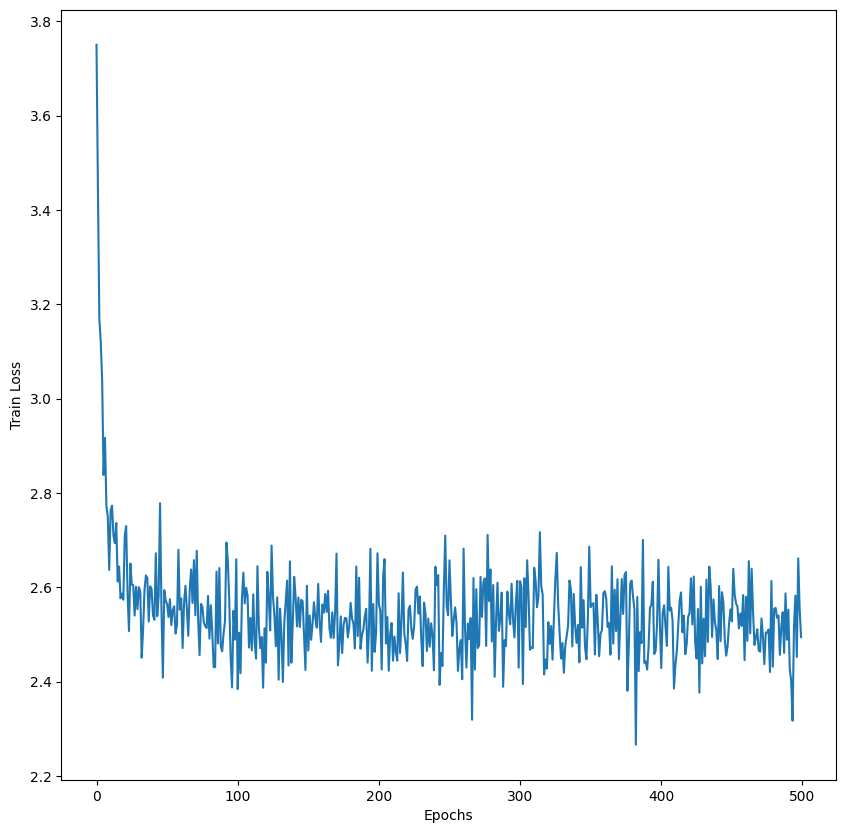

In [114]:
plt.figure(figsize = (10, 10))
plt.plot(steps, losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

In [141]:
# Sample new names from the approximated M matrix of probs distribution. M== probs
gen = torch.Generator().manual_seed(20098+ 1002)
for i in range(20): # generate 20 names
  out = []
  idx = 0
  while True:
    p = probs[idx] # fetch the prob distribution of the jth next char given the ith char
    idx = torch.multinomial(p, num_samples = 1, 
                            replacement = True,
                            generator = gen).item()
    out.append(itos[idx])
    if idx == 0:
      break
  print(f">>>> The {i} generated name is: {''.join(out)}")



>>>> The 0 generated name is: nynahlyna.
>>>> The 1 generated name is: ahbiaaahhsn.
>>>> The 2 generated name is: l.
>>>> The 3 generated name is: nyahraiiahl.
>>>> The 4 generated name is: niasniatniuyatniiiyerold.
>>>> The 5 generated name is: elsdok.
>>>> The 6 generated name is: yvaonie.
>>>> The 7 generated name is: enia.
>>>> The 8 generated name is: naat.
>>>> The 9 generated name is: leahm.
>>>> The 10 generated name is: rhnidy.
>>>> The 11 generated name is: .
>>>> The 12 generated name is: eeyvs.
>>>> The 13 generated name is: .
>>>> The 14 generated name is: naaaasjel.
>>>> The 15 generated name is: s.
>>>> The 16 generated name is: .
>>>> The 17 generated name is: u.
>>>> The 18 generated name is: ahlhsj.
>>>> The 19 generated name is: .
